Testing with max_dict_size = 512...
Testing with max_dict_size = 1024...
Testing with max_dict_size = 2048...
Testing with max_dict_size = 4096...

--- Summary of LZW Performance ---

Max Dict Size: 512
  Compression Ratio: 0.127
  Encoded Codes Length: 1165011
  Is Lossless: True

Max Dict Size: 1024
  Compression Ratio: 0.130
  Encoded Codes Length: 1138519
  Is Lossless: True

Max Dict Size: 2048
  Compression Ratio: 0.137
  Encoded Codes Length: 1076737
  Is Lossless: True

Max Dict Size: 4096
  Compression Ratio: 0.150
  Encoded Codes Length: 984943
  Is Lossless: True


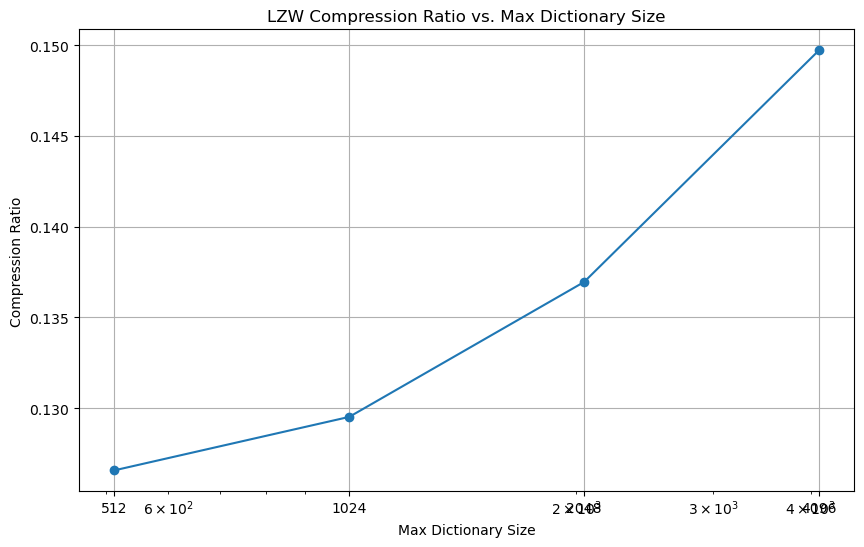

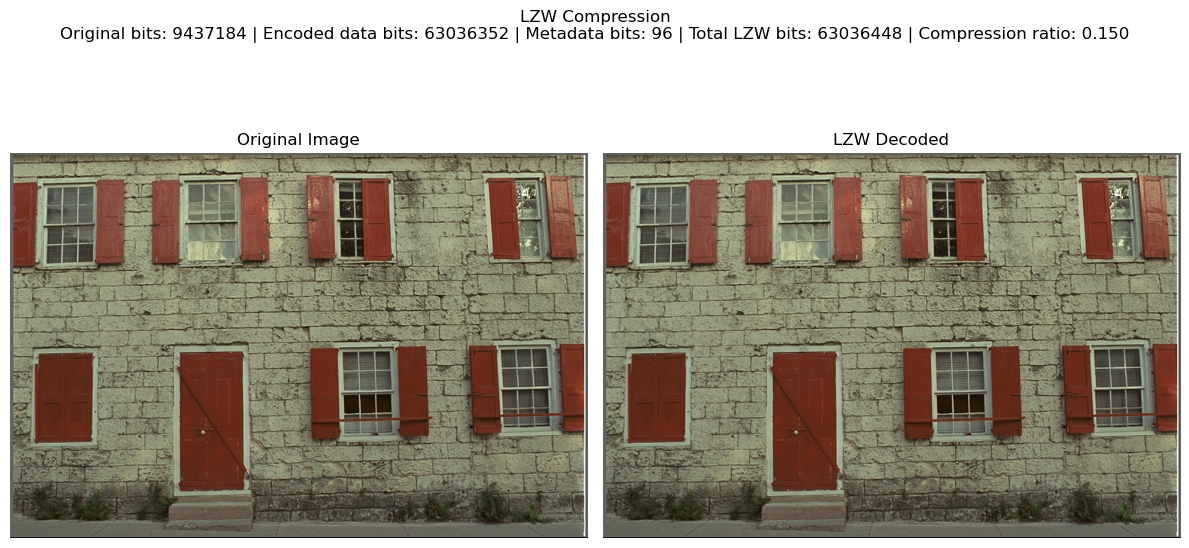

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def lzw_encode(image_data, max_dict_size=4096):
    """
    Encodes image data using the LZW algorithm.
    """
    flat_data = image_data.ravel().tobytes()
    
    dictionary = {bytes([i]): i for i in range(256)}
    next_code = 256
    
    encoded_data = []
    current_sequence = b""
    
    for byte in flat_data:
        current_byte = bytes([byte])
        new_sequence = current_sequence + current_byte
        
        if new_sequence in dictionary:
            current_sequence = new_sequence
        else:
            encoded_data.append(dictionary[current_sequence])
            if len(dictionary) < max_dict_size:
                dictionary[new_sequence] = next_code
                next_code += 1
            current_sequence = current_byte
            
    if current_sequence:
        encoded_data.append(dictionary[current_sequence])
        
    return encoded_data

def lzw_decode(encoded_data, shape):
    """
    Decodes LZW-encoded data back into an image array.
    """
    if not encoded_data:
        return np.zeros(shape, dtype=np.uint8)

    dictionary = {i: bytes([i]) for i in range(256)}
    next_code = 256
    
    result = []
    prev_code = encoded_data.pop(0)
    current_entry = dictionary[prev_code]
    result.append(current_entry)
    
    for code in encoded_data:
        if code in dictionary:
            entry = dictionary[code]
        elif code == next_code:
            entry = current_entry + current_entry[:1]
        else:
            raise ValueError("Invalid LZW code during decoding.")
            
        result.append(entry)
        
        new_entry = current_entry + entry[:1]
        dictionary[next_code] = new_entry
        next_code += 1
        
        current_entry = entry

    decoded_bytes = b"".join(result)
    decoded_image_array = np.frombuffer(decoded_bytes, dtype=np.uint8).reshape(shape)
    
    return decoded_image_array

def calculate_compression_ratio(original_data, encoded_data):
    """
    Calculates the compression ratio.
    """
    # Use the uint8 version for accurate byte size calculation
    original_size_bytes = original_data.size * original_data.itemsize
    
    # Size of encoded data: number of codes * size of a code in bytes
    # The LZW codes can have varying bit lengths. For a simple approximation,
    # we use the item size of the numpy array of codes.
    encoded_size_bytes = len(encoded_data) * np.array(encoded_data).itemsize
    
    if encoded_size_bytes == 0:
        return float('inf')
        
    return original_size_bytes / encoded_size_bytes

def display_side_by_side(original, decoded, ratio, orig_bits, encoded_bits, metadata_bits, total_bits):
    """
    Display original and decoded images side by side with LZW compression statistics.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display original image
    # Use np.clip to handle float vs uint8 display
    axes[0].imshow(np.clip(original, 0, 1) if np.issubdtype(original.dtype, np.floating) else original, 
                   cmap='gray' if len(original.shape) == 2 else None)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Display decoded image
    axes[1].imshow(np.clip(decoded, 0, 1) if np.issubdtype(decoded.dtype, np.floating) else decoded, 
                   cmap='gray' if len(decoded.shape) == 2 else None)
    axes[1].set_title("LZW Decoded")
    axes[1].axis("off")
    
    plt.suptitle(
        f"LZW Compression\n"
        f"Original bits: {orig_bits} | "
        f"Encoded data bits: {encoded_bits} | "
        f"Metadata bits: {metadata_bits} | "
        f"Total LZW bits: {total_bits} | "
        f"Compression ratio: {ratio:.3f}",
        fontsize=12
    )
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

def test_lzw_dict_sizes(image_data, dict_sizes):
    """
    Tests LZW compression with different maximum dictionary sizes.
    
    Args:
        image_data (np.ndarray): The uint8 NumPy array of the image.
        dict_sizes (list): A list of integer maximum dictionary sizes to test.
        
    Returns:
        dict: A dictionary containing metrics for each max_dict_size.
    """
    results = {}
    
    for size in dict_sizes:
        print(f"Testing with max_dict_size = {size}...")
        
        # Encode the image
        encoded_codes = lzw_encode(image_data, max_dict_size=size)
        
        # Decode the image
        decoded_image_uint8 = lzw_decode(encoded_codes, image_data.shape)
        
        # Verify lossless compression
        is_equal = np.array_equal(image_data, decoded_image_uint8)
        
        # Calculate metrics
        orig_bits = image_data.size * 8
        encoded_bits = len(encoded_codes) * np.array(encoded_codes).itemsize * 8
        metadata_bits = len(image_data.shape) * 32  # Estimate for storing shape
        total_bits = encoded_bits + metadata_bits
        
        if total_bits > 0:
            compression_ratio = orig_bits / total_bits
        else:
            compression_ratio = float('inf')
        
        results[size] = {
            'compression_ratio': compression_ratio,
            'encoded_codes_len': len(encoded_codes),
            'is_lossless': is_equal
        }
        
    return results

def plot_lzw_results(results):
    """
    Plots the compression ratio vs. max dictionary size.
    
    Args:
        results (dict): The results from test_lzw_dict_sizes.
    """
    sizes = sorted(results.keys())
    ratios = [results[size]['compression_ratio'] for size in sizes]
    
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, ratios, marker='o')
    plt.title('LZW Compression Ratio vs. Max Dictionary Size')
    plt.xlabel('Max Dictionary Size')
    plt.ylabel('Compression Ratio')
    plt.xscale('log') # Use a log scale for dictionary size
    plt.grid(True)
    plt.xticks(sizes, labels=[str(s) for s in sizes])
    plt.show()


# --- Main execution block with float-to-uint8 conversion and metric calculation ---


if __name__ == "__main__":
    # 1. Read and convert the image
    original_image_float = plt.imread('/mnt/769EC2439EC1FB9D/vsc_projs/DIP/kodim01.png')
    original_image_uint8 = (original_image_float * 255).astype(np.uint8)

    # 2. Define a list of dictionary sizes to test
    # These sizes correspond to 9-bit, 10-bit, 11-bit, and 12-bit code lengths.
    dict_sizes_to_test = [512, 1024, 2048, 4096]
    
    # 3. Test LZW for different dictionary sizes
    results = test_lzw_dict_sizes(original_image_uint8, dict_sizes_to_test)
    
    # 4. Print detailed results
    print("\n--- Summary of LZW Performance ---")
    for size, data in results.items():
        print(f"\nMax Dict Size: {size}")
        print(f"  Compression Ratio: {data['compression_ratio']:.3f}")
        print(f"  Encoded Codes Length: {data['encoded_codes_len']}")
        print(f"  Is Lossless: {data['is_lossless']}")
        
    # 5. Visualize the performance
    plot_lzw_results(results)
    
    # Optional: Display the final image from the last test case
    last_size = dict_sizes_to_test[-1]
    last_encoded_codes = lzw_encode(original_image_uint8, max_dict_size=last_size)
    last_decoded_image_uint8 = lzw_decode(last_encoded_codes, original_image_uint8.shape)
    
    last_orig_bits = original_image_uint8.size * 8
    last_encoded_bits = len(last_encoded_codes) * np.array(last_encoded_codes).itemsize * 8
    last_metadata_bits = len(original_image_uint8.shape) * 32
    last_total_bits = last_encoded_bits + last_metadata_bits
    last_ratio = last_orig_bits / last_total_bits
    
    display_side_by_side(original_image_float, last_decoded_image_uint8, last_ratio, 
                         last_orig_bits, last_encoded_bits, last_metadata_bits, last_total_bits)


Lossless compression successful: Original and decoded images are identical.


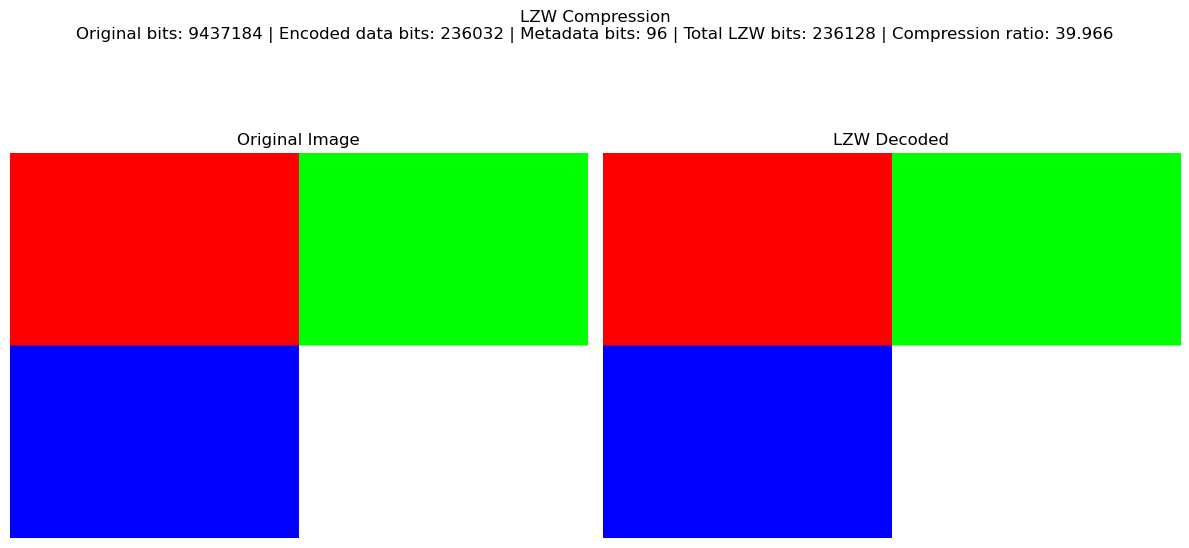

In [9]:
def create_high_redundancy_image(width=768, height=512):
    """
    Creates a sample image with repetitive patterns that compress well.
    """
    image = np.zeros((height, width, 3), dtype=np.uint8)
    # Fill quadrants with solid, repetitive colors
    image[:height//2, :width//2] = [255, 0, 0] # Red
    image[:height//2, width//2:] = [0, 255, 0] # Green
    image[height//2:, :width//2] = [0, 0, 255] # Blue
    image[height//2:, width//2:] = [255, 255, 255] # White
    return image


# example 2
original_image_uint8 = create_high_redundancy_image()
# 2. Encode the image
max_dict_size = 4096
encoded_codes = lzw_encode(original_image_uint8, max_dict_size)

# 3. Decode the image
decoded_image_uint8 = lzw_decode(encoded_codes, original_image_uint8.shape)

# Verify lossless compression
is_equal = np.array_equal(original_image_uint8, decoded_image_uint8)
if is_equal:
    print("Lossless compression successful: Original and decoded images are identical.")
else:
    print("Error: Images are not identical after decoding.")

# 4. Calculate metrics for display
orig_bits = original_image_uint8.size * 8

# Calculate encoded data bits (approximate)
# This is a rough estimation. The LZW code size depends on the current dictionary size.
# For a simple display, we assume the average code size is based on max_dict_size.
# log2(max_dict_size) bits per code would be more accurate, but this simplifies it.
encoded_bits = len(encoded_codes) * np.array(encoded_codes).itemsize * 8

# Estimate metadata bits (e.g., for storing image dimensions)
# The image dimensions are stored as metadata. 
# Here, we assume a fixed size (e.g., 3 integers for shape * 32 bits/int)
metadata_bits = len(original_image_uint8.shape) * 32 

total_bits = encoded_bits + metadata_bits

# Recalculate ratio based on bits for consistency
compression_ratio = orig_bits / total_bits

# 5. Visualize the results using the new function
display_side_by_side(original_image_uint8, decoded_image_uint8, compression_ratio, 
                     orig_bits, encoded_bits, metadata_bits, total_bits)
